In [2]:
#load packages
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/")
import boto3
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse import vstack as vstack
import chess, chess.pgn
import time
import multiprocessing as mp
import os
import re
import pandas as pd
from datetime import datetime
import pickle
import gzip
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
# constants
BOARD_LENGTH = 768 #chess board is 8 x 8 and 12 different pieces

## Vector representation of chess board
# v = 1 x BOARD_LENGTH
#
# White = Upper Case, black = lower case
# Piece order: P, N, B, R, Q, K, p, n, b, r, q, k
# Board order:
#    Start at square a1. Move across the columns to square h1.
#    Then go up a row to square a2. Move across the columns to square h2.
#    Repeat until square h8
#    i.e. 0 - a1, 1 - b1, ..., 7 - h1, 8 - a2, ..., 63 - h8
#
# Board vector indices: 
# v[0,...,63] = P, v[64,...,127] = N, ..., v[704,...,767] = k
# v[0,...,7] = row 1; v[8,...,15] = row 2, ..., v[56,...,63] = row 8
# v[0] = col a, v[1] = col b, ..., v[7] = col h

PIECE_OFFSETS = {'P': 0, 'N': 64, 'B': 128, 'R': 192, 'Q': 256, 'K': 320,
                 'p': 384, 'n': 448, 'b': 512, 'r': 576, 'q': 640, 'k': 704}

RESULTS_DICT = {'1-0': 1,'1/2-1/2': 0,'0-1': -1}
RESULTS_LIST = [1, 0, -1]

# Neural Net

In this section, we build, train and test a feedforward neural network that calculates the probability a board position results in a win for white. We first use a small sample of games to determine a reasonable number of hidden nodes fro the neural network. The program ParseData.py converts the pgn data into binary vectors and saves the output. The program PrepareTrainTest.py takes the binary vectors and creates four training datasets and one testing dataset. We split the data up so that the data could be processed by different cores using mini-batch parallelism. We compare the time to train the neural network of our implementation of mini-batch parallelism versus none.

## Neural Net Class

The code uses sparse matrices to siginificantly decrease the amount of memory and instructions needed on a CPU to train the neural net

In [4]:
class BoardFunction:
    
    def __init__(self, numInputNodes, numHiddenNodes, numOutputNodes, maxIter, maxEpochs):
        # layers
        self.numInputNodes = numInputNodes
        self.numHiddenNodes = numHiddenNodes
        self.numOutputNodes = numOutputNodes
        
        # weight matrices
        self.hiddenWeights = np.empty((self.numInputNodes, self.numHiddenNodes), dtype = np.float_)
        self.hiddenBiases = np.empty((1, self.numHiddenNodes), dtype = np.float_)
        self.outputWeights = np.empty((self.numHiddenNodes, self.numOutputNodes), dtype = np.float_)
        self.outputBiases = np.empty((1, self.numOutputNodes), dtype = np.float_)
        
        # learning parameters
        self.learningRate = 0.1
        self.minRate = 0.00001
        self.miniBatchSize = 512
        self.maxIter = maxIter
        self.maxEpochs = maxEpochs
        self.minTol = 10**(-7)
        self.decay = True # if true decreses the learning rate if loss plateaus
        self.logPath = '../log'
        
    def initWeights(self, seed = None):
        '''
        Randomly initializes the weight matrices
        '''
        if seed != None:
            np.random.seed(seed)
            
        self.hiddenWeights = np.random.normal(loc = 0.1, size = self.hiddenWeights.shape)
        self.hiddenBiases = np.random.normal(loc = 0.1, size = self.hiddenBiases.shape)
        self.outputWeights = np.random.normal(loc = 0.1, size = self.outputWeights.shape)
        self.outputBiases = np.random.normal(loc = 0.1, size = self.outputBiases.shape)
        
    def _relu(self, X):
        '''
        X - matrix
        
        returns element wise max of X and zero
        '''
        
        return(np.maximum(X,0))
    
    def _softmax(self, X):
        shiftX = X - np.amax(X, axis = 1, keepdims = True)
        exps = np.exp(shiftX)
        sums = np.sum(exps, axis = 1, keepdims = True)
        
        return(exps / sums)
    
    def predict(self, board):
        '''
        board - csr matrix: sparse row matrix of encoded board positions
    
        returns probs - numpy array: a matrix containing the probability of a win, draw or loss
        '''
        
        numBoards = board.shape[0]
        
        hiddenWeights = board.dot(self.hiddenWeights)
        hiddenBiases = np.outer(np.ones((numBoards, 1), dtype = np.float_), self.hiddenBiases)
        hiddenIn = hiddenWeights + hiddenBiases
        hiddenOut = self._relu(hiddenIn) #rectified linear element-wise max with zero
        
        outputWeights = hiddenOut.dot(self.outputWeights)
        outputBiases = np.outer(np.ones((numBoards, 1), dtype = np.float_), self.outputBiases)
        outputIn = outputWeights + outputBiases
        outputOut = self._softmax(outputIn)
        
        minProb = np.finfo(np.float64).tiny # avoid numerical issues with zero probs
        
        return(np.maximum(outputOut, minProb))
    
    def loss(self, board, result):
        '''
        board - csr matrix: sparse row matrix of encoded board positions
        result - 1d array: one hot enconding of result
        
        returns the cross entropy (multinomial log-likelihood) for the sample
        '''
        
        probs = self.predict(board)
        aveLogLikelihood = -np.sum(result * np.log(probs)) / board.shape[0]
        
        return(aveLogLikelihood)
    
    def calcGradients(self, board, result):
        '''
        board - csr matrix: sparse row matrix of encoded board positions
        result - 1d array: one hot enconding of result
        
        J = cross entropy loss function
        '''
        
        numBoards = board.shape[0]
        
        # feed forward
        hiddenWeights = board.dot(self.hiddenWeights)
        hiddenBiases = np.outer(np.ones((numBoards, 1), dtype = np.float_), self.hiddenBiases)
        hiddenIn = hiddenWeights + hiddenBiases
        hiddenOut = self._relu(hiddenIn) #rectified linear element-wise max with zero
        
        outputWeights = hiddenOut.dot(self.outputWeights)
        outputBiases = np.outer(np.ones((numBoards, 1), dtype = np.float_), self.outputBiases)
        outputIn = outputWeights + outputBiases
        outputOut = self._softmax(outputIn)
        
        # compute gradients
        d1 = outputOut - result
        d2 = d1.dot(self.outputWeights.transpose()) * np.sign(hiddenOut)
        
        # D J(outputWeights)
        DJoutW = hiddenOut.transpose().dot(d1) / numBoards
        
        # D J(outputBiases)
        DJoutB = np.sum(d1.dot(np.eye(result.shape[1])), axis = 0) / numBoards
        
        # D J(hiddenWeights)
        DJhidW = board.transpose().dot(d2) / numBoards
        
        # D J(hiddenBiases)
        DJhidB = np.sum(d2, axis = 0) / numBoards
        
        return(DJoutW, DJoutB, DJhidW, DJhidB)
    
    def saveIter(self, fileName, fileNum, numEpoch, numIter, loss):
        line = str(fileNum) + ',' + str(numEpoch) + ',' + str(numIter) + ',' + str(loss) + '\n'
        with open(fileName, mode ='a') as f:
            f.write(line)
    
    def saveWeights(self, fileName):
        print('Saving weights to ' + fileName)
        np.savez_compressed(fileName,
                            hiddenWeights = self.hiddenWeights,
                            hiddenBiases = self.hiddenBiases,
                            outputWeights = self.outputWeights,
                            outputBiases = self.outputBiases)
        print('Done saving weights')
        
    def applyGradients(self, DJoutW, DJoutB, DJhidW, DJhidB):
        '''
        
        updates each weight matrix by subtracting off the learning rate times the gradient
        '''
        
        self.hiddenWeights = self.hiddenWeights - self.learningRate * DJhidW
        self.hiddenBiases = self.hiddenBiases - self.learningRate * DJhidB
        self.outputWeights = self.outputWeights - self.learningRate * DJoutW
        self.outputBiases = self.outputBiases - self.learningRate * DJoutB
    
    def train(self, xTrain, yTrain, logFile, fileNum):
        
        # setup training
        resultOneHot = MultiLabelBinarizer(classes = RESULTS_LIST)
        batchFeeder = self.nextBatch(xTrain.shape[0], self.miniBatchSize)
    
        numIter = 0
        changedEpoch = 1
        loss = np.zeros(10, dtype=np.float_) # saves the 10 previous checkpoint losses
        stop = False
        
        print('Start training hidden nodes ' + str(self.numHiddenNodes))
        print('Learning rate is {}'.format(self.learningRate))
    
        while stop == False:
            # get batch
            firstInd, lastInd, numEpoch = next(batchFeeder)
            board = xTrain[firstInd:lastInd]
            result = resultOneHot.fit_transform(yTrain[firstInd:lastInd])
            
            # calc and save loss every 50 iterations
            if numIter % 50 == 0:
                i = (numIter // 50) % 10
                loss[i] = self.loss(board, result)
                #print('Iteration: {0} Loss: {1}'.format(numIter, loss[i]))
                self.saveIter(logFile, fileNum, numEpoch, numIter, loss[i])
            
            # save parameters
            if numIter % 10000 == 0:
                # save parameters
                print('Saving weights learned so far')
                boardFunc.saveWeights(modelFile)
        
            # calc and apply gradients
            DJoutW, DJoutB, DJhidW, DJhidB = self.calcGradients(board, result)
            self.applyGradients(DJoutW, DJoutB, DJhidW, DJhidB)
        
            # update number of iterations
            numIter = numIter + 1
        
            # check if max number of iterations or epochs
            if numIter > self.maxIter or numEpoch > self.maxEpochs:
                stop = True
                self.saveIter(logFile, fileNum, numEpoch - 1, numIter - 1, loss[i])
                print('Stopped training at {} iterations and {} epochs for hidden nodes {}'.format(
                    numIter, numEpoch, self.numHiddenNodes))
                
            # if decay is true change learning rate at epoch
            if self.decay == True and numEpoch - changedEpoch > 10:
                changedEpoch = numEpoch
                self.learningRate = self.learningRate / 10
                print('Epoch {}. Changed learning rate to {}'.format(numEpoch, self.learningRate))

    
    def nextBatch(self, totObs, batchSize):
        # initialize
        numBatches = totObs // batchSize
        tail = totObs % batchSize
        batch = 0
        epoch = 0
    
        # generator
        while True:
            batch = (batch + 1) % numBatches
            if batch == 1:
                firstInd = 0
                lastInd = batchSize
                epoch = epoch + 1
            elif batch == 0:
                firstInd = lastInd
                lastInd = lastInd + batchSize + tail
            else:
                firstInd = lastInd
                lastInd = lastInd + batchSize
        
            yield firstInd, lastInd, epoch
        
        

## Neural Net Built on Sample Data

We build a neural net on a sample of data in order to determine a resonable number of hidden nodes to use to
train the full model. We use a sample of data so that the training times are short enough that the model can be iterated on as a function of number of hidden nodes on a laptop. First, we write the code to implement a feed forward neural network with one hidden layer. The hidden layer uses the rectified linear function, and the output layer uses the softmax function. Cross-entropy (multinomial likelihood) is used as the loss function

In [ ]:
# load sample data
dataDir = '../test/clean'
xTrainFiles = [os.path.join(dataDir, 'xTrain'+str(i)+'.npz') for i in range(os.cpu_count())]
yTrainFiles = [os.path.join(dataDir, 'yTrain'+str(i)+'.npz') for i in range(os.cpu_count())]
xTrain_ = []
yTrain_ = []

for fx, fy in zip(xTrainFiles,yTrainFiles):
    xTrain_.append(scipy.sparse.load_npz(fx))
    yTrain_.append(np.load(fy)['arr_0'])
    
xTrain1 = scipy.sparse.vstack(xTrain_)
yTrain1 = np.concatenate(yTrain_)

xTest1 = scipy.sparse.load_npz(os.path.join(dataDir, 'xTest.npz'))
yTest1 = np.load(os.path.join(dataDir, 'yTest.npz'))['arr_0']

del [xTrain_, yTrain_]

In [ ]:
# define worker function for bias-variance graph
def evalNumHiddenNodes(numHiddenNodes):
    '''
    numHiddenNodes - int: number of hidden nodes
    
    returns tuple of training loss and testing loss
    '''
    
    resultOneHot = MultiLabelBinarizer(classes = RESULTS_LIST)
    trainingLoss = 0
    testingLoss = 0
    
    print('Hidden Nodes {}'.format(numHiddenNodes))
    
    for i in range(4):
        print('Hidden Nodes {} round {}'.format(numHiddenNodes, i))
        xTrain_, xTest_, yTrain_, yTest_ = train_test_split(vstack((xTrain,xTest)), np.vstack((yTrain,yTest)),
                                                            train_size = 0.8, random_state = i + 1)
        f = BoardFunction(BOARD_LENGTH, numHiddenNodes, 3, 200000, 20)
        f.initWeights(i + 1) #set seed for reproducibility
        f.train(xTrain_, yTrain_)
        trainingLoss = trainingLoss + f.loss(xTrain_, resultOneHot.fit_transform(yTrain_)) / 4
        testingLoss = testingLoss + f.loss(xTest_, resultOneHot.fit_transform(yTest_)) / 4
    
    return(trainingLoss, testingLoss)

def worker(taskQueue, outQueue):
    while not taskQueue.empty():
        n = taskQueue.get()
        trainingLoss, testingLoss = evalNumHiddenNodes(n)
        outQueue.put((n, trainingLoss, testingLoss))

def main():
    # set number of processes to number of cores
    numProcesses = os.cpu_count()
    
    # create queues
    taskQueue = mp.Queue()
    outQueue = mp.Queue()

    # create task queue with range of hidden nodes to evaluate
    # hiddenNodes = [2, 3, 5] + [i for i in range(10,100,10)] + [i for i in range(100,1100,100)]
    hiddenNodes = [2000]
    # submit tasks
    for i in hiddenNodes:
        taskQueue.put(i)
        
    # Start worker processes
    workers = []
    for i in range(numProcesses):
        workers.append(mp.Process(target=worker, args=(taskQueue, outQueue)))
        workers[i].daemon = True
        workers[i].start()
    
    # Block until all items in the queue have been retrieved and processed.
    for w in workers:
        w.join()
        
    # Get and print results
    print('Results:')
    for i in range(len(hiddenNodes)):
        print('\t', outQueue.get())

if __name__ == '__main__':
    main()

## Neural Net of Full Data

Based on data below, it appears that 100 is a reasonable number of hidden nodes for 294,428 total board positions in the data (of which 261,013 are unique)

In [ ]:
dataDir = '../data/clean'
xTrainFiles = [os.path.join(dataDir, 'xTrain' + str(i) + '.npz') for i in range(4)]
yTrainFiles = [os.path.join(dataDir, 'yTrain' + str(i) + '.npz') for i in range(4)]

In [ ]:
# initialize model
logFile = '../log/model_full_log.txt'
modelFile = '../model/model_full_weights.npz'
boardFunc = BoardFunction(BOARD_LENGTH, 32000, 3, 200000, 1)
boardFunc.initWeights()

# load through data files and train
for fx, fy, fileNum in zip(xTrainFiles, yTrainFiles, range(4)):
    # load data file
    xTrain = scipy.sparse.load_npz(fx)
    yTrain = np.load(fy)['arr_0']
    
    # train on data chunk
    print('File ' + str(fileNum))
    boardFunc.train(xTrain, yTrain, logFile, fileNum)
    # save parameters
    boardFunc.saveWeights(modelFile)
    # change learning rate
    boardFunc.learningRate = boardFunc.learningRate
    print()
    
    

In [ ]:
boardFunc.outputBiases

In [ ]:
# memory usage in GiB
dataGiB = xTrain.nnz * xTrain.dtype.itemsize / (1024**3)
colGiB = xTrain.indices.shape[0] * xTrain.indices.dtype.itemsize / (1024**3)
rowGiB = xTrain.indptr.shape[0] * xTrain.indptr.dtype.itemsize / (1024**3)
print('Boards total GiB: ' + str(dataGiB + colGiB + rowGiB))

dataGiB = yTrain.shape[0] * yTrain.dtype.itemsize / (1024**3)
print('Results total GiB: ' + str(dataGiB))

print('Number of Board Positions: ' + str(xTrain.shape[0]))

# Notes for Report

From Nitish Shirish Keskar, Dheevatsa Mudigere, Jorge Nocedal, Mikhail Smelyanskiy, Ping Tak Peter Tang. On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima. https://arxiv.org/abs/1609.04836 :

The stochastic gradient descent method and its variants are algorithms of choice for many Deep Learning tasks. These methods operate in a small-batch regime wherein a fraction of the training data, usually 32--512 data points, is sampled to compute an approximation to the gradient. It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize.

Results of Training on Small sample

Hidden Nodes | Training Loss | Testing Loss

(2, 1.0100619674035751, 1.0091796152110315)  
(3, 1.007482207571287, 1.0066383559043466)  
(5, 1.0055554590398994, 1.005023531581839)  
(10, 1.0025096545121017, 1.0014980079650992)  
(20, 0.99807602689486419, 0.99720644407485393)  
(30, 0.99399420182901932, 0.99333884848858678)  
(40, 0.99328607731974783, 0.99274053552888364)  
(50, 0.98944021407430505, 0.98889769712408171)  
(60, 0.9863994075288971, 0.98619975531255344)  
(70, 0.9840429241801889, 0.98366685082558569)  
(80, 0.98182486550393266, 0.98176263405153508)  
(90, 0.98028274459491105, 0.980031350473068)  
(100, 0.9799195740106964, 0.98035206647664563)  
(200, 0.96067535070753229, 0.96146881491348635)  
(300, 0.94619056342381636, 0.94883739830555913)  
(400, 0.93211902538475155, 0.93581461710661318)  
(500, 0.92147218306629264, 0.92625700867560345)  
(600, 0.91413918085285739, 0.91944739566420786)  
(700, 0.90181913873124897, 0.90894246695116876)  
(800, 0.89781815061434322, 0.90720724133753783)  
(900, 0.90179592770302441, 0.91455607692081964)  
(1000, 0.90999905019713589, 0.92927055677816228)  
(1100, 0.91730496589972221, 0.94067571972455488)  
(1200, 0.93264025467090339, 0.96354963998689114)  
(1300, 1.0002378034267088, 1.0420546608713139)  
(1400, 1.0517057482093932, 1.1026789728980475)  
(1500, 1.1478033939379304, 1.221898995717857)  
(1600, 1.2890920718141325, 1.3911260895054278)  
(1700, 1.3804783955461297, 1.5090146237581545)  
(1800, 1.4683900170764266, 1.6101375997534371)  
(1900, 1.6144862319988333, 1.7925763627477731)  
(2000, 1.7326184003683225, 1.9542765976494103)

In [ ]:
def convertBoardToVec(board):
    '''convertBoardToVec(board object) -> array
        
        board object = object of Board Class from chess,
        array = 1d np array of length BOARD_LENGTH
        
    This function loops converts a board to its corresponding vector representation
    '''
    
    v = np.zeros(BOARD_LENGTH, dtype = np.int8)

    pieces = board.piece_map()
    for sq in pieces:
        piece = pieces[sq]
        ind = PIECE_OFFSETS[piece.symbol()] + sq
        v[ind] = 1
        
    return(v)

In [ ]:
f = BoardFunction(BOARD_LENGTH, 10, 3, 200000, 20)
f.initWeights(1) #set seed for reproducibility
f.train(xTrain, yTrain)
resultOneHot = MultiLabelBinarizer(classes = RESULTS_LIST)
trainingLoss = f.loss(xTrain, resultOneHot.fit_transform(yTrain))
testingLoss = f.loss(xTest, resultOneHot.fit_transform(yTest))

In [ ]:
print(trainingLoss, testingLoss)

In [74]:
import tensorflow as tf

In [ ]:
# layer parameters
numInputNodes = BOARD_LENGTH
numHiddenNodes = 32000
numOutputNodes = 3

# input and output placeholders
#x = tf.sparse_placeholder(tf.float64, shape = [None, numInputNodes])
x = tf.placeholder(tf.float64, shape = [None, numInputNodes])
y = tf.placeholder(tf.float64, shape = [None, numOutputNodes])

# layer weights and biases
hiddenWeights = tf.Variable(evalFunc.hiddenWeights)
hiddenBiases = tf.Variable(evalFunc.hiddenBiases)
outputWeights = tf.Variable(evalFunc.outputWeights)
outputBiases = tf.Variable(evalFunc.outputBiases)

# computations
# hidden = tf.nn.relu(tf.add(tf.sparse_tensor_dense_matmul(x, hiddenWeights), hiddenBiases))
hidden = tf.nn.relu(tf.add(tf.matmul(x, hiddenWeights), hiddenBiases))
output = tf.add(tf.matmul(hidden, outputWeights), outputBiases)

# probs
tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output)
# cost function
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    currCost = sess.run([cost], feed_dict = {x: xTest.toarray(), y: resultOneHot.fit_transform(yTest)})

In [ ]:
currCost

In [5]:
#Code to transform model weights to c
#Read in weights and export as csv file
weights = np.load('../model/model_full_weights.npz')

In [6]:
hw = weights['hiddenWeights']
hb = weights['hiddenBiases']
ow = weights['outputWeights']
ob = weights['outputBiases']

In [ ]:
hw.tofile('../model/hw_weights')
hb.tofile('../model/hb_weights')
ow.tofile('../model/ow_weights')
ob.tofile('../model/ob_weights')

In [7]:
weights.close()

In [8]:
ow.shape

(32000, 3)

In [ ]:
hw[2][0:5]


In [ ]:
hb[0][0:5]

In [ ]:
print(ow[2][0:3])
print(ow[3][0:3])

In [ ]:
ob[0][0:5]

In [9]:
evalFunc = BoardFunction(768,32000,3,1,1)

In [10]:
evalFunc.hiddenWeights = hw
evalFunc.hiddenBiases = hb
evalFunc.outputWeights = ow
evalFunc.outputBiases = ob

In [101]:
board = np.zeros(shape = (1,768));
board[0,100] = 1;
board[0,200] = 1;
board[0,300] = 1;
board[0,88] = 1;
board[0,400] = 1;
board[0,500] = 1;
board[0,542] = 1;

In [102]:
evalFunc.predict(board)

array([[ 0.95302613,  0.01882871,  0.02814516]])

In [103]:
np.sum(evalFunc.predict(board) * np.array([[1,0,-1]]))

0.9248809684958742

In [47]:
numBoards = 1
        
hiddenWeights = board.dot(evalFunc.hiddenWeights)
hiddenBiases = np.outer(np.ones((numBoards, 1), dtype = np.float_), evalFunc.hiddenBiases)
hiddenIn = hiddenWeights + hiddenBiases
hiddenOut = evalFunc._relu(hiddenIn) #rectified linear element-wise max with zero

In [51]:
print(hiddenWeights[0,120:130])
print(hiddenBiases[0,0:5])
print(hiddenIn[0,0:5])
print(hiddenOut[0,450:470])

[-3.53140389 -0.05436956 -1.55526973  0.79106861  0.83817631  0.41159211
 -0.26906471  0.74794157 -1.27518978 -2.40060382]
[-2.23596907 -1.02252381 -1.48166693 -1.85591248 -2.50453441]
[-3.82736216 -1.75827792 -1.79254594 -1.6382281  -2.44271143]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.02663283  0.          0.          0.          0.08756336
  0.          2.21515236  0.          0.          0.          0.          0.        ]


In [85]:
outputWeights = hiddenOut.dot(evalFunc.outputWeights)
outputBiases = np.outer(np.ones((numBoards, 1), dtype = np.float_), evalFunc.outputBiases)
outputIn = outputWeights + outputBiases
outputOut = evalFunc._softmax(outputIn)

In [86]:
print(outputWeights)
print(outputBiases)
print(outputIn)
print(outputOut)

[[ -4.61338212  10.56582991  12.35300495]]
[[ 0.82741939 -0.66027762  0.7655464 ]]
[[ -3.78596273   9.90555229  13.11855135]]
[[  4.37855709e-08   3.86794631e-02   9.61320493e-01]]


In [68]:
np.exp(-3.785946) / (np.exp(-3.785946) + np.exp(9.905580) + np.exp(13.118540))

4.3786734226554488e-08

In [69]:
np.exp(9.905580)/ (np.exp(-3.785946) + np.exp(9.905580) + np.exp(13.118540))

0.03868091562129812

In [70]:
np.exp(13.118540) / (np.exp(-3.785946) + np.exp(9.905580) + np.exp(13.118540))

0.96131904059196771

In [71]:
(2**9.905580)/ ((2**-3.785946) + (2**9.905580) + (2**13.118540))

0.09734647044120374

In [80]:
1/(1+ np.exp(3.785946))

0.022184091213665616

In [84]:
1/(1+ np.exp(4.61338212))

0.0098208119746326268

In [104]:
import sys

In [105]:
sys.path

['',
 '/Users/brianlubeck/anaconda/lib/python36.zip',
 '/Users/brianlubeck/anaconda/lib/python3.6',
 '/Users/brianlubeck/anaconda/lib/python3.6/lib-dynload',
 '/Users/brianlubeck/anaconda/lib/python3.6/site-packages',
 '/Users/brianlubeck/anaconda/lib/python3.6/site-packages/Sphinx-1.5.1-py3.6.egg',
 '/Users/brianlubeck/anaconda/lib/python3.6/site-packages/aeosa',
 '/Users/brianlubeck/anaconda/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg',
 '/Users/brianlubeck/anaconda/lib/python3.6/site-packages/IPython/extensions',
 '/Users/brianlubeck/.ipython',
 '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/']

In [106]:
np.version.version

'1.11.3'

In [107]:
## Training graph

d = [2, 1.0100619674035751, 1.0091796152110315,
3, 1.007482207571287, 1.0066383559043466,
5, 1.0055554590398994, 1.005023531581839,
10, 1.0025096545121017, 1.0014980079650992,
20, 0.99807602689486419, 0.99720644407485393,
30, 0.99399420182901932, 0.99333884848858678,
40, 0.99328607731974783, 0.99274053552888364,
50, 0.98944021407430505, 0.98889769712408171,
60, 0.9863994075288971, 0.98619975531255344,
70, 0.9840429241801889, 0.98366685082558569,
80, 0.98182486550393266, 0.98176263405153508,
90, 0.98028274459491105, 0.980031350473068,
100, 0.9799195740106964, 0.98035206647664563,
200, 0.96067535070753229, 0.96146881491348635,
300, 0.94619056342381636, 0.94883739830555913,
400, 0.93211902538475155, 0.93581461710661318,
500, 0.92147218306629264, 0.92625700867560345,
600, 0.91413918085285739, 0.91944739566420786,
700, 0.90181913873124897, 0.90894246695116876,
800, 0.89781815061434322, 0.90720724133753783,
900, 0.90179592770302441, 0.91455607692081964,
1000, 0.90999905019713589, 0.92927055677816228,
1100, 0.91730496589972221, 0.94067571972455488,
1200, 0.93264025467090339, 0.96354963998689114,
1300, 1.0002378034267088, 1.0420546608713139,
1400, 1.0517057482093932, 1.1026789728980475,
1500, 1.1478033939379304, 1.221898995717857,
1600, 1.2890920718141325, 1.3911260895054278,
1700, 1.3804783955461297, 1.5090146237581545,
1800, 1.4683900170764266, 1.6101375997534371,
1900, 1.6144862319988333, 1.7925763627477731,
2000, 1.7326184003683225, 1.9542765976494103]

In [113]:
#Results of Training on Small sample

hiddenNodes = [None]*int(96/3)
trainingLoss = [None]*int(96/3)
testingLoss = [None]*int(96/3)
for i in range(int(len(d)/3)):
    for j in range(3):
        if j == 0:
            hiddenNodes[i] = d[i*3]
        elif j == 1:
            trainingLoss[i] = d[i*3+1]
        else:
            testingLoss[i] = d[i*3+2]

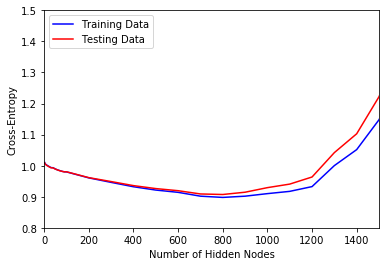

In [152]:
import matplotlib.pyplot as plt
plt.plot(hiddenNodes, trainingLoss, 'b', label = 'Training Data')
plt.plot(hiddenNodes, testingLoss, 'r', label ='Testing Data')
plt.ylim(0.8,1.5)
plt.xlim(0,1500)
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [153]:
import pandas as pd

In [156]:
df = pd.read_csv('../log/model_full_log.txt', header = None)

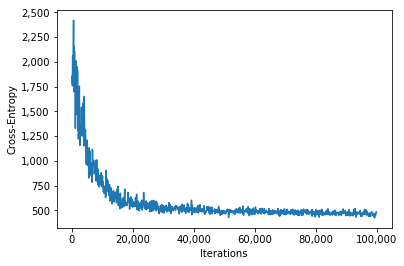

In [163]:
plt.plot(df.iloc[:1000,2], df.iloc[:1000,3])
#plt.ylim(0.8,1.5)
#plt.xlim(0,1500)
plt.xlabel('Iterations')
plt.ylabel('Cross-Entropy')
#plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()